<center>
    <img src="./images/adsp_logo.png">
</center>

### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta


# Wiener Filters

Filters to reduce the influence of **noise or distortions**.

Assume: x(n) is the original signal, y(n) is the distorted signal. 

Example: y(n)=x(n)+v(n), where v(n) is is assumed to be independent white noise.


- **Wiener filter** $h_W(n)$ : $y(n)*h_W(n)\rightarrow x(n)$ (**signal fidelity**, the reconstruction is close to the original, for instance for de-noising an image or audio signal, where the audio signal does not need to be deterministic)

The goal here is an approximation of the original signal x(n) in the least mean squared sense, meaning we would like to **minimize the mean quadratic error** between the filtered and the original signal.

We have a filter system with Wiener Filter $h_W(n)$:

$$\large
x(n)=y(n)*h_W(n)
$$

meaning we filter our distorted signal y(n) with our still unknown filter $h_W(n)$.

The convolution $h_W(n)$ of (with filter length L) with y(n) can be written as  a matrix multiplication:

$$\large
x(n)=\sum_{m=0}^{L-1}y(n-m)\cdot h_W(m)
$$

Alternatively, we can run the sum in the other direction,

$$\large
x(n)=\sum_{m=0}^{L-1}y(n-L+1+m)\cdot h_W(L-1-m)
$$

Now let's define 2 vectors. The first is a vector of the **past L samples of our noisy signal y**, up to the present sample at time n, (bold face font to indicate that it is a vector)

$$\large
\boldsymbol y(n)=[y(n-L+1),...,y(n-1),y(n)]$$

The next vector contains the **time reversed impulse response**,

$$\large
\boldsymbol h_W=[h_W(L-1),...,h_W(1),h_W(0)]
$$

Using those 2 vectors, we can rewrite our convolution equation above as a vector multiplication,

$$\large
x(n)= \boldsymbol y(n) \cdot \boldsymbol {h_W}^T
$$

**Observe** that $\boldsymbol h_W$ has no time index because it already contains all the samples of the time-reversed impulse response, and is constant.

We can now also put the output signal x(n) into the **row vector**,

$$\large
\boldsymbol x =[x(0),x(1),...]
$$

To obtain this column vector, we simply assemble all the row vectors of our noisy signal $\boldsymbol y(n)$ into a matrix $\boldsymbol A$,


$$\large
\boldsymbol A =\left[\matrix{\boldsymbol y(0) \\ \boldsymbol y(1) \\ \vdots  } \right] $$

With this matrix, we obtain the result of our convolution at all time steps n to

$$\large
\boldsymbol  A \cdot \boldsymbol  {h_W}^T = \boldsymbol  x^T$$

this is just another way of writing our convolution.

For the example of a filter length of $h_W$ of L=2 hence we get,

$$\large
 \left [ \matrix{y(0) & y(1) \\ y(1) & y(2) \\ y(2) & y(3)\\ \vdots & \vdots }  \right ] \cdot \left [ \matrix{h_W(1) \\ h_W(0) }  \right ] =\left[\matrix{ x(0) \\  x(1) \\ x(2) \\ \vdots  } \right] $$

**Observe** again that the vector $\boldsymbol h_w$ in this equation is the time reversed impulse response of our filter. This is now the **matrix multiplication** formulation of our **convolution**.

We can now obtain the minimum mean squared error **solution** of this matrix multiplication using the so-called Moore-Penrose **Pseudo Inverse**

In [1]:
%%html
<iframe src='http://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse', width=900, height=400></iframe>

This pseudo-inverse finds the column vector $\boldsymbol h^T$ which minimizes the distance to a given $\boldsymbol x$ with the matrix $\boldsymbol A$ (which contains our signal to be filtered):

$$\large
\boldsymbol A \cdot \boldsymbol {h_W}^T \rightarrow \boldsymbol x^T$$

Matrix $\boldsymbol A$ and vector $\boldsymbol x$ are known (this is done in a **“trainings”-phase** to obtain the Wiener filter coefficients $\boldsymbol h_W$, from noisy signals in matrix **A** and clean signals in vector **x**), and vector $\boldsymbol h_w$ is unknown so far. After the trainings-phase the filter can also be applied to **similar signals**.

This problem can be solved exactly if the matrix $\boldsymbol A$ is **square and invertible**. Just multiplying the equation with $\boldsymbol A^{-1}$ from the left would give us the solution

$$\large
\boldsymbol h_W^T= \boldsymbol A ^{-1 }\cdot \boldsymbol x^T
$$

This cannot be done, if $\boldsymbol A$ is **non-square**, for instance if it has many more rows than columns. In this case we don't have an exact solution, but many solutions that come close to $\boldsymbol x$. We would like to obtain the solution which comes **closest** to $\boldsymbol x$ in a mean squared error distance sense (also called **Euclidean Distance**).

This solution is derived using the Pseudo-Inverse:

$$\large
\boldsymbol A^T \cdot \boldsymbol A \cdot \boldsymbol {h_W}^T = \boldsymbol A ^T \cdot \boldsymbol x^T
$$

Here, $\boldsymbol A ^T \cdot \boldsymbol A$ is now a square matrix, and usually invertible, such that we obtain our solution

$$\large
\boldsymbol {h_W}^T = (\boldsymbol A ^T \cdot \boldsymbol A) ^{-1} \boldsymbol A ^T \cdot \boldsymbol x^T$$

This $\boldsymbol h_w$ is now the **solution** we where looking for. This solution has the minimum mean squared distance to the un-noisy version of all solutions.

## Python Example for denoising speech

In [2]:
from scipy import signal as sp
import numpy as np
import IPython.display as ipd
import librosa as lbr
import wave
import struct

In [3]:
# Define waveread
def wavread(sndfile):
    wf=wave.open(sndfile,'rb');
    nchan=wf.getnchannels();
    bytes=wf.getsampwidth();
    rate=wf.getframerate();
    length=wf.getnframes();
    print("Number of channels: ", nchan);
    print("Number of bytes per sample:", bytes);
    print("Sampling rate: ", rate);
    print("Number of samples:", length);
    data=wf.readframes(length);
    if bytes==2:
        shorts = (struct.unpack( 'h' * length, data ));
    else:
        shorts = (struct.unpack( 'B' * length, data ));
    wf.close;
    return shorts, rate;

# Load audio file
x, fs = wavread('./audio/fspeech.wav')

Number of channels:  1
Number of bytes per sample: 2
Sampling rate:  32000
Number of samples: 207612


In [4]:
# Play audio
display(ipd.Audio(x, rate = fs ))

In [5]:
#additive zero mean white noise (for -2**15<x<+2**15):
y=x+0.1*(np.random.random(np.shape(x))-0.5)*2**15
display(ipd.Audio(y, rate = fs ))

In [6]:
#make x and y  matrices and transpose them into a column:
x=np.matrix(x).T
y=np.matrix(y).T

In [7]:
#we assume 10 coefficients for our Wiener filter. 
#10 to 12 is a good number for speech signals.
A = np.matrix(np.zeros((100000, 10)))
for m in range(100000):
    A[m,:] = y[m+np.arange(10)].T
#Our matrix has 100000 rows and 10 colums:
print (A.shape)


(100000, 10)


In [8]:
#Compute Wiener Filter:
#Trick: allow (flipped) filter delay of 5 samples to get better working denoising. 
#This corresponds to the center of our Wiener filter.
#The desired signal hence is x[5:100005].
#Observe: Since we have the matrix type, operator '*' is  matrix multiplication!
import matplotlib.pyplot as plt
h=np.linalg.inv(A.T*A)*A.T*x[5:100000+5]
plt.figure(figsize=(8,6))
plt.plot(np.flipud(h)) 
plt.xlabel('Sample')
plt.ylabel('value')
plt.title('Impulse Response of Wiener Filter')
plt.grid()

Observe that for this non-flipped impulse response we see a delay of 4 samples (the peak is a sample number 4).

Its frequency response is:

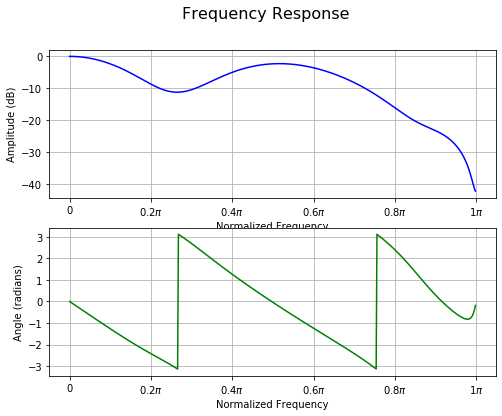

In [9]:
# Frequency Response

from scipy.signal import freqz
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

w, h_response  = freqz(np.flipud(h))

fig=plt.figure(figsize=(8,6))
fig.suptitle('Frequency Response', fontsize=16)
plt.subplot(2,1,1)
plt.plot(w/np.pi, 20 * np.log10(abs(h_response), where=abs(h_response) > 0), 'b')
#plt.ylim((-0.001,0.001))
plt.ylabel('Amplitude (dB)')
plt.xlabel('Normalized Frequency')
plt.grid()
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
plt.subplot(2,1,2)
angles = np.angle(h_response)
plt.plot(w/np.pi, angles, 'g')
plt.ylabel('Angle (radians)')
plt.xlabel('Normalized Frequency')
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
   lambda val,pos: '{:.0g}$\pi$'.format(val) if val !=0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=0.2))
plt.grid()


Here we can see that the resulting filter has a somewhat **low pass characteristic**, because our speech signal has energy mostly at low frequencies. 

At high frequencies we have mostly noise, hence it makes sense to have more attenuation there! This attenuation curve of this Wiener filter also has some similarity to the speech spectrum. If we compare it with the spectrum of our white noise, then we see that at low frequencies the speech is dominating, and at high frequencies noise is dominating. Hence we need to remove or attenuate  that latter, noisy, part of the spectrum.

We can plot the spectra of the speech and the noise together: 

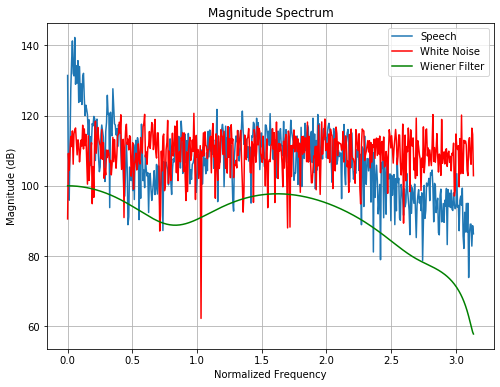

In [10]:
w,Hspeech=sp.freqz(x);
w,Hnoise=sp.freqz(0.1*(np.random.random(np.shape(x))-0.5)*2**15)
w,Hw=sp.freqz(np.flipud(h))
plt.figure(figsize=(8,6))
plt.plot(w,20*np.log10(abs(Hspeech))); 
plt.plot(w,20*np.log10(abs(Hnoise)),'r');
#plot and shift the filter into the vicinity of the signal:
plt.plot(w,20*np.log10(abs(Hw))+100,'g')
plt.xlabel('Normalized Frequency')
plt.ylabel('Magnitude (dB)')
plt.legend(('Speech', 'White Noise', 'Wiener Filter'))
plt.title('Magnitude Spectrum')
plt.grid()

Here we see that **speech dominates the spectrum only at low and middle frequencies**, noise at the other frequencies, hence it makes sense to suppress those noisy frequencies.

Now we can filter it. For “lfilter” function argument we need to convert the matrix type into a 1 dimensional array type:

In [11]:
xw = sp.lfilter(np.array(np.flipud(h).T)[0],[1],np.array(y.T)[0])

In [12]:
display(ipd.Audio(xw, rate = fs ))

We can hear that the signal now sounds more “muffled”, the higher frequencies are indeed attenuated, which reduces the influence of the noise. But it is still a question if it actually “sounds” better to the human ear.

This Wiener filter could now also be applied to **other speech signals, with similar frequency characteristics** for signal and noise.

Let's compare the mean (squared) quadratic error (**mse**), to see if it is indeed reduced, and by how much. For the noisy signal it is

In [13]:
print( np.shape(x))
#Compute the quadratic error for the first 200000 samples:
print(sum(np.power(y[:200000]-x[:200000],2))/200000)


(207612, 1)
[[896041.05549326]]


For the Wiener filtered signal it is (taking into account 4 samples delay from our filter, beginning to peak).

In [14]:
print(np.sum(np.power(xw[4:200004]-x[:200000].T,2))/200000)

372399.7161173361


We can see that the mean quadratic error is indeed less than a fourth as much as for the noisy version y(n)!

Let's take a look at the matrix $A^T\cdot A$ which we used in the computation,

In [15]:
print((A.T*A).shape)
(A.T*A)

(10, 10)


matrix([[1.08721851e+12, 9.24113804e+11, 8.68628795e+11, 9.05902303e+11,
         9.00380275e+11, 8.56283734e+11, 8.32799860e+11, 8.02542802e+11,
         7.67504182e+11, 7.45626229e+11],
        [9.24113804e+11, 1.08721695e+12, 9.24113432e+11, 8.68627926e+11,
         9.05900710e+11, 9.00380906e+11, 8.56284299e+11, 8.32801213e+11,
         8.02544674e+11, 7.67503287e+11],
        [8.68628795e+11, 9.24113432e+11, 1.08722059e+12, 9.24115928e+11,
         8.68630974e+11, 9.05901837e+11, 9.00379032e+11, 8.56281116e+11,
         8.32801452e+11, 8.02545601e+11],
        [9.05902303e+11, 8.68627926e+11, 9.24115928e+11, 1.08722207e+12,
         9.24117528e+11, 8.68632035e+11, 9.05900694e+11, 9.00377243e+11,
         8.56282012e+11, 8.32801780e+11],
        [9.00380275e+11, 9.05900710e+11, 8.68630974e+11, 9.24117528e+11,
         1.08722359e+12, 9.24119073e+11, 8.68630765e+11, 9.05898852e+11,
         9.00378968e+11, 8.56282145e+11],
        [8.56283734e+11, 9.00380906e+11, 9.05901837e+11, 8.6

We can see that it is a 10x10 matrix in our example for a Wiener filter with 10 filter taps. In this matrix, the next row  looks almost like the previous line, but shifted by 1 sample to the right.

**Observe** that in general this matrix $\boldsymbol A^T \cdot \boldsymbol A $ **converges** to the **autocorrelation matrix **of signal $y(n)$ if the length of the signal in the matrix goes to infinity!

    
 $$\large
 \boldsymbol A ^T 
 \cdot \boldsymbol A 
\rightarrow \boldsymbol R_{yy}=\left [ \matrix{r_{yy}(0) & r_{yy}(1) & r_{yy}(2) & \cdots  \\ r_{yy}(1) & r_{yy}(0) & r_{yy(1)} & \cdots 
\\ \vdots & \vdots & \vdots & \vdots}  \right ] 
 $$   

(The autocorrelation of signal y is
$r_{yy}(m)=\sum _ {n=-\infty} ^ \infty y(n) \cdot y(n+m)$)

Since one row of this matrix is the shifted by one sample version of the one above, it is called a “**Toeplitz Matrix**”.

The expression $\boldsymbol A^T\cdot \boldsymbol x^T$ in our formulation of the Wiener filter becomes the cross correlation vector


$$\large
\boldsymbol A^T \cdot \boldsymbol x^T \rightarrow \boldsymbol r_{xy}=\left [ \matrix{r_{xy(0)}  \\ r_{xy}(1) \\ \vdots}  \right ] 
$$
(where the cross correlation function is
$
r_{xy}(m)=\sum _ {n=-\infty} ^ \infty y(n) \cdot x(n+m)
$
)

**Observe:** In the receiver we usually don't have the un-noisy signal x(n), but we can **estimate** the above **cross correlation** function.

Hence our expression for the Wiener filter $\boldsymbol h^T = (\boldsymbol A ^T \cdot \boldsymbol A) ^{-1} \boldsymbol A ^T \cdot \boldsymbol x^T$ becomes

$$\large
\boldsymbol h^T = (\boldsymbol R_{yy}) ^{-1} \boldsymbol r_{xy}$$

This matrix form is also called the “**Yule-Walker equation**”, and the general statistical formulation is called the “**Wiener-Hopf equation**”. 

*See also: M.H. Hayes, “Statistical Signal Processing and Modelling”, Wiley.

This general statistical formulation now also has the advantage, that we can design a Wiener Filter by just **knowing the statistics**, the **auto-correlation function** of our noisy signal, and the **cross-correlation function** of our noisy and original signal. Observe that this auto-correlation and cross-correlation can also be obtained from the **power-spectra**(cross-power spectra, the product of the 2 spectra) of the respective signals.

The power spectrum of the noisy signal can usually be measured, since it is the signal to filter, and the **spectrum of the original signal x(n)** usually has to be **estimated** (using assumptions about it).

For instance, we know typical speech spectra. If we want to adapt a Wiener filter in a receiver, we take this typical speech spectrum, and measure the noise level at the receiver. Then we can add the power spectrum of the noise to the power spectrum of the speech to obtain the power spectrum of the noisy speech (which is the power cross spectrum of the clean speech and noise, or the Fourier Transform of cross correlation, because we assume the speech and the noise uncorrelated).

To use Wiener-Hopf, we simply apply the inverse Fourier Transforms to the power spectra.

That is sufficient to compute the Wiener filter coefficients, using above formulations.

## Scipy Wiener Filter Example: Iron Maiden - The Number of the Beast Speech Intro

Load audio:

In [16]:
# Load audio
x , sr =lbr.load('./audio/Iron Maiden - The Number Of The Beast.mp3', offset=13, duration=12)
x/=np.abs(x).max()

In [17]:
%%html
<iframe src='https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.wiener.html', width=1000, height=500></iframe>

Add random noise:

In [30]:
np.random.seed(27)
maiden_noise = x + 0.3*(np.random.random(np.shape(x))-0.5)
display(ipd.Audio(maiden_noise, rate = sr ))

Filter with Scipy Wiener Filter

In [42]:
maiden_filtered = sp.wiener(maiden_noise, mysize=51)
display(ipd.Audio(maiden_filtered, rate = sr ))

Check MSE:

In [43]:
print('MSE: Noise',sum(np.power(maiden_noise[:200000]-x[:200000],2))/200000)
print('MSE: FIltered',sum(np.power(maiden_filtered[:200000]-x[:200000],2))/200000)

MSE: Noise 0.007509346173119453
MSE: FIltered 0.0007780840010710013
